In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv


In [2]:
import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
#from nltk.corpus import stopwords
import string
from nltk.tokenize import RegexpTokenizer
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
Using TensorFlow backend.


In [3]:
clothing = pd.read_csv("../input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv", index_col=0)
print(clothing.shape)
clothing.head(5)

(23486, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
clothing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [5]:
clothing.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,918.118709,43.198544,4.196032,0.822362,2.535936
std,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


In [6]:
#  Checking for Missing Values
clothing.isnull().values.any()

True

In [7]:
clothing.isnull().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

Text(0.5, 1.0, 'Distribution of Age')

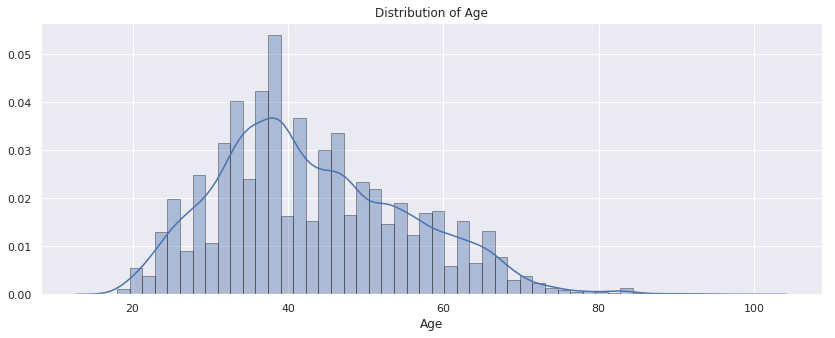

In [8]:
sns.set(style="darkgrid")
plt.figure(figsize= (14,5))
sns.distplot(clothing['Age'], hist_kws=dict(edgecolor="k")).set_title("Distribution of Age")

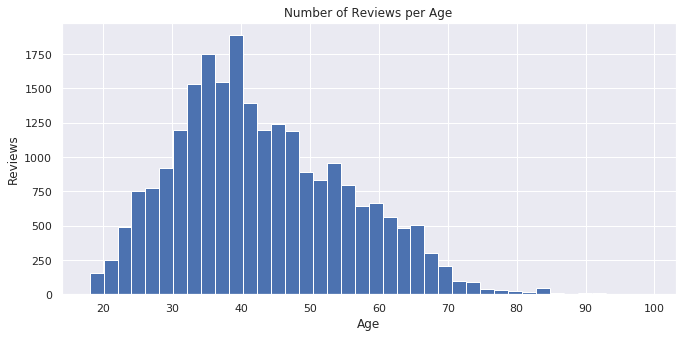

In [9]:
sns.set(rc={'figure.figsize':(11,5)})
plt.hist(clothing.Age, bins=40)
plt.xlabel('Age')
plt.ylabel('Reviews')
plt.title('Number of Reviews per Age');

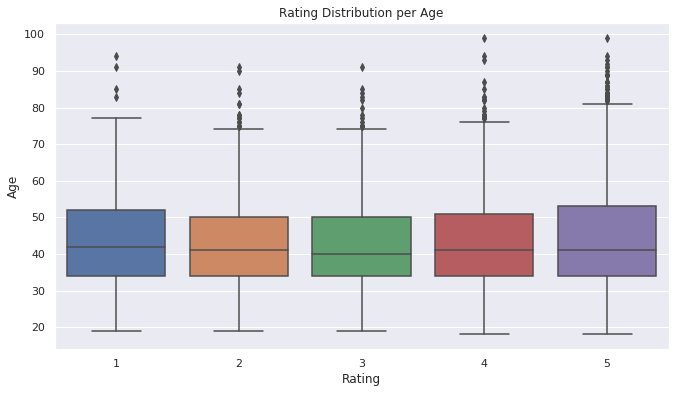

In [10]:
sns.set(rc={'figure.figsize':(11,6)})
sns.boxplot(x = 'Rating', y = 'Age', data = clothing)
plt.title('Rating Distribution per Age');

Text(0.5, 1.0, 'Counts Vs Department Name')

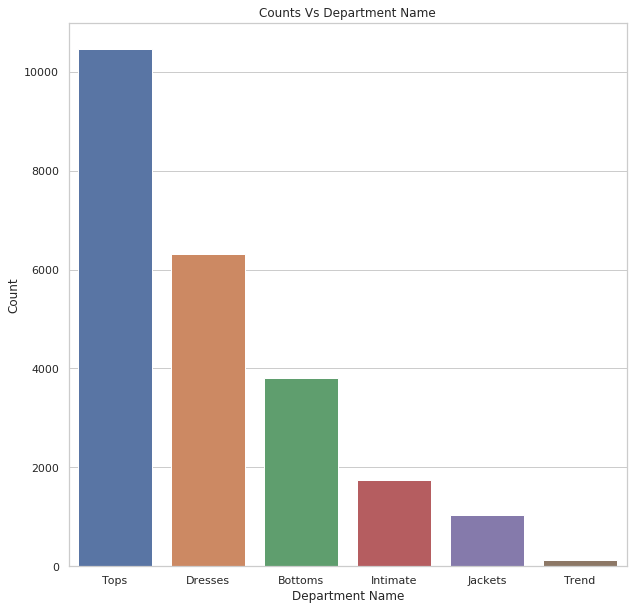

In [11]:
z = clothing.groupby(by=['Department Name'],as_index=False).count().sort_values(by='Class Name',ascending=False)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['Department Name'],y=z['Class Name'], data=z)
plt.xlabel("Department Name")
plt.ylabel("Count")
plt.title("Counts Vs Department Name")

Text(0.5, 1.0, 'Counts Vs Division Name')

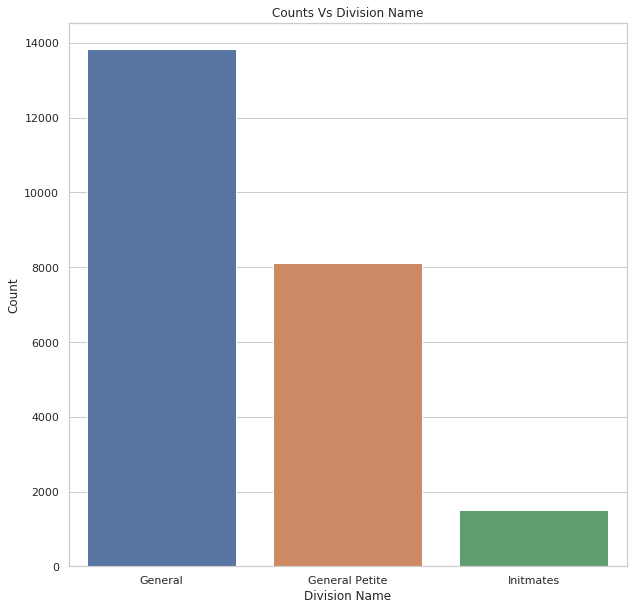

In [12]:
w = clothing.groupby(by=['Division Name'],as_index=False).count().sort_values(by='Class Name',ascending=False)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=w['Division Name'],y=w['Class Name'], data=w)
plt.xlabel("Division Name")
plt.ylabel("Count")
plt.title("Counts Vs Division Name")

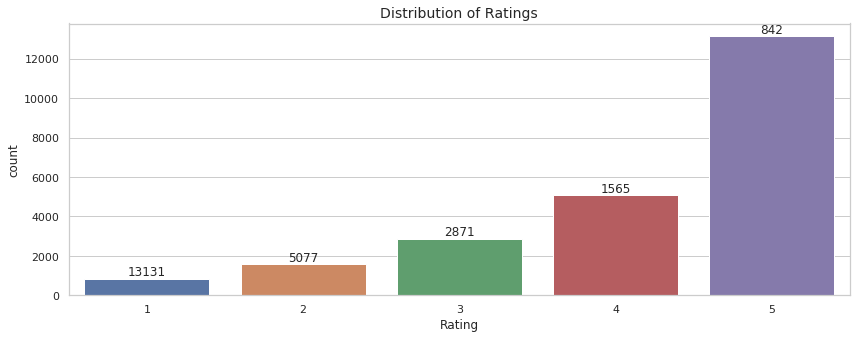

In [13]:
#  The Product Rating Distribution
plt.figure(figsize= (14,5))
ax=sns.countplot(x='Rating', data=clothing)
ax.set_title("Distribution of Ratings", fontsize=14)

x=clothing['Rating'].value_counts()

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

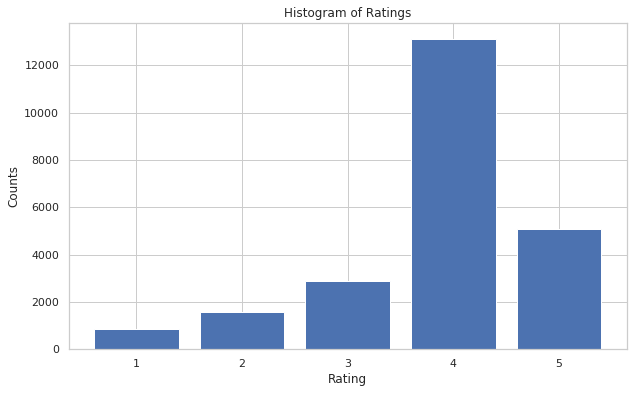

<Figure size 576x288 with 0 Axes>

In [14]:
h = clothing["Rating"].value_counts()
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(clothing["Rating"].unique(),h)
plt.xlabel("Rating")
plt.ylabel("Counts")
plt.title("Histogram of Ratings")
plt.figure(figsize=(8,4))
ax.grid(True)
plt.rcParams['axes.axisbelow'] = True

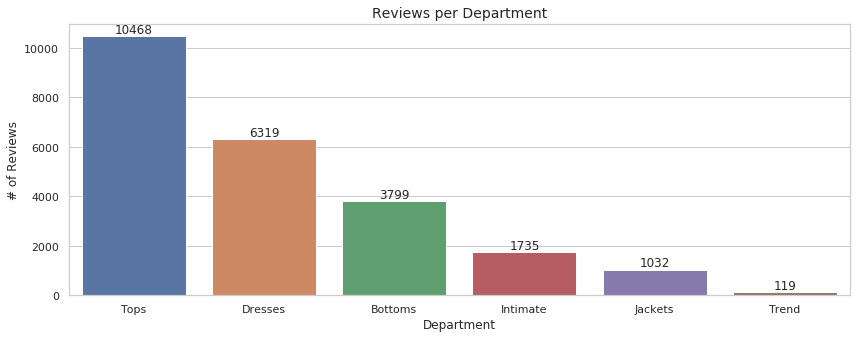

In [15]:
#  Number of Reviews per Product Category
plt.figure(figsize= (14,5))
ax=sns.countplot(x='Department Name', data=clothing, order = clothing['Department Name'].value_counts().index)
ax.set_title("Reviews per Department", fontsize=14)
ax.set_ylabel("# of Reviews", fontsize=12)
ax.set_xlabel("Department", fontsize=12)

x=clothing['Department Name'].value_counts()

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

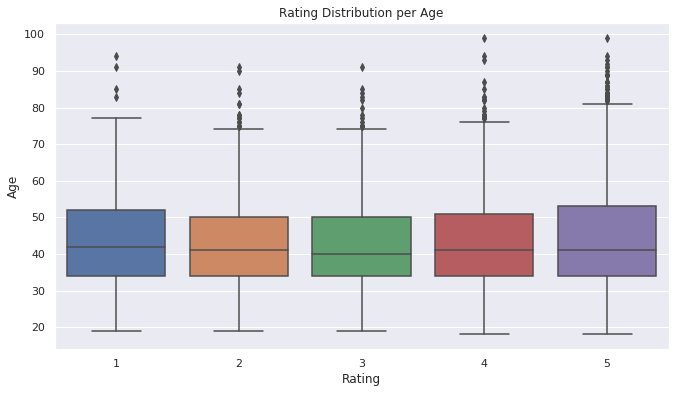

In [16]:
sns.set(rc={'figure.figsize':(11,6)})
sns.boxplot(x = 'Rating', y = 'Age', data = clothing)
plt.title('Rating Distribution per Age');

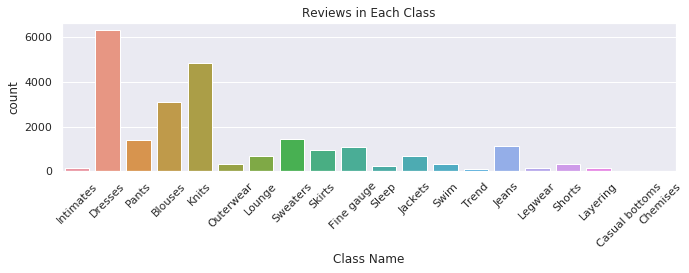

In [17]:
#  Distribution of Class
ax = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax = plt.xticks(rotation=45)
ax = sns.countplot(clothing['Class Name'])
ax = plt.title("Reviews in Each Class")

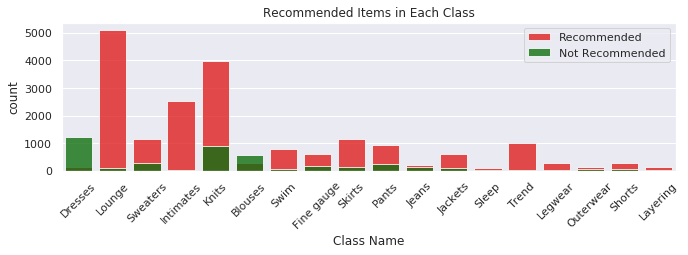

In [18]:
#  Rate of Recommendations
recommended = clothing[clothing['Recommended IND']==1]
not_recommended = clothing[clothing['Recommended IND']==0]

ax0 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax0 = plt.xticks(rotation=45)
ax0 = sns.countplot(recommended['Class Name'], color="red", alpha = 0.8, label = "Recommended")
ax0 = sns.countplot(not_recommended['Class Name'], color="green", alpha = 0.8, label = "Not Recommended")
ax0 = plt.title("Recommended Items in Each Class")
ax0 = plt.legend()

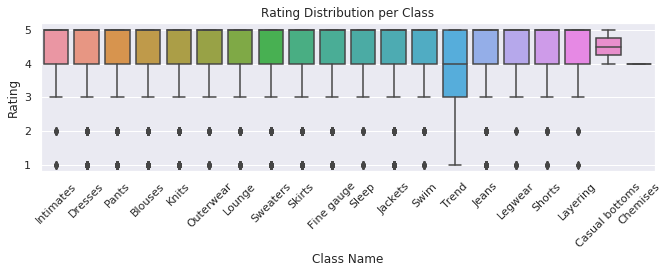

In [19]:
ax1 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax1 = plt.xticks(rotation=45)
ax1 = sns.boxplot(x="Class Name", y="Rating", data=clothing)
ax1 = plt.title('Rating Distribution per Class')

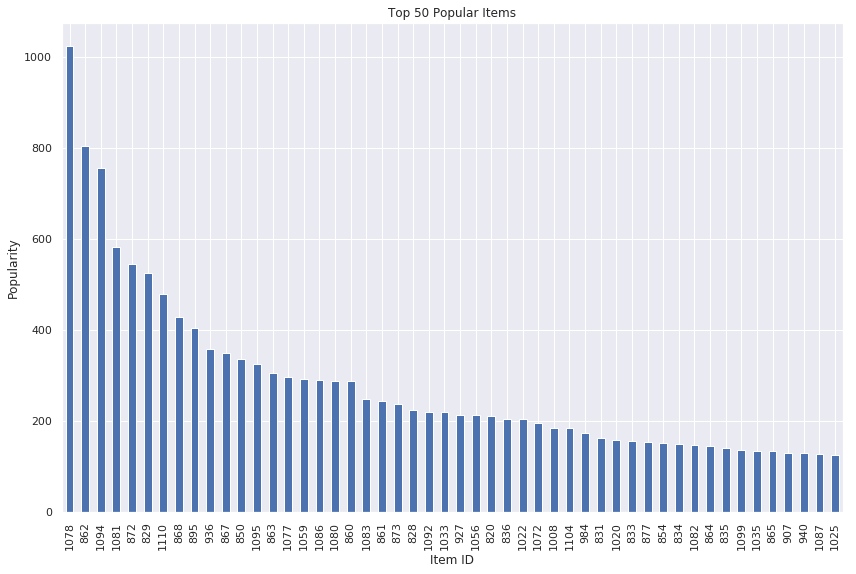

In [20]:
# The Most Popular Item
fig = plt.figure(figsize=(14, 9))
plt.xticks(rotation=45)
plt.xlabel('Item ID')
plt.ylabel('Popularity')
plt.title("Top 50 Popular Items")
clothing['Clothing ID'].value_counts()[:50].plot(kind='bar');

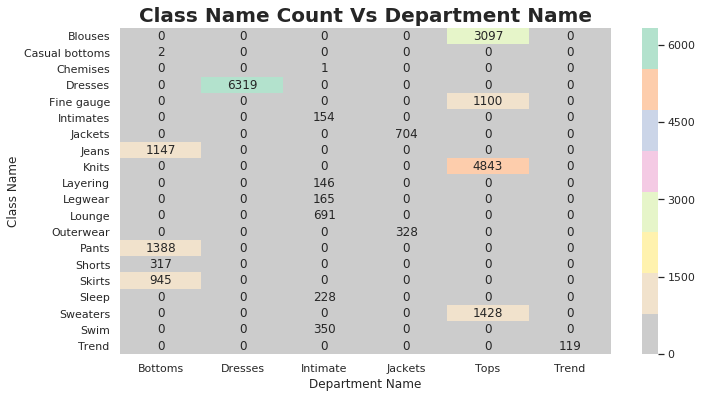

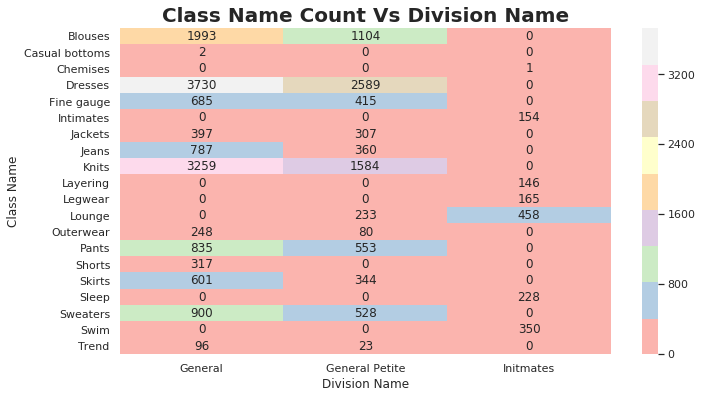

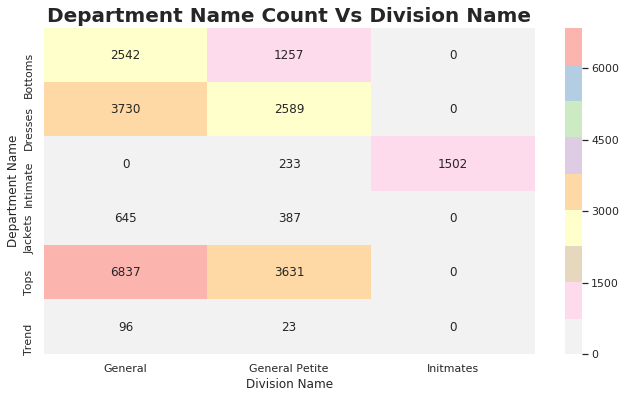

In [21]:
#  Correlation Plot of Department,Division and Class Against Each Other
sns.heatmap(pd.crosstab(clothing['Class Name'], 
        clothing["Department Name"]),
            annot=True,fmt='g', cmap="Pastel2_r")
plt.title("Class Name Count Vs Department Name",fontsize=20,fontweight='bold')
plt.show()

sns.heatmap(pd.crosstab(clothing['Class Name'], clothing["Division Name"]),
            annot=True,fmt='g', cmap="Pastel1")
plt.title("Class Name Count Vs Division Name",fontsize=20,fontweight='bold')

plt.show()

sns.heatmap(pd.crosstab(clothing['Department Name'], clothing["Division Name"]),
            annot=True,fmt='g', cmap="Pastel1_r")
plt.title("Department Name Count Vs Division Name",fontsize=20,fontweight='bold')

plt.show()

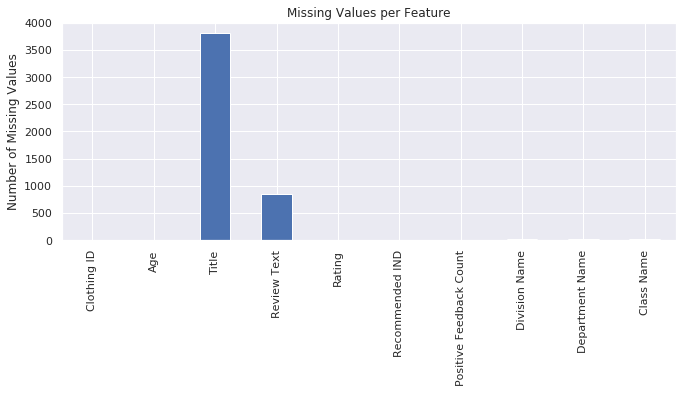

In [22]:
#  The Amount of Missing Values per Feature
sns.set(rc={'figure.figsize':(11,4)})
pd.isnull(clothing).sum().plot(kind='bar')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values per Feature');

In [23]:
clothing.dropna(subset=['Review Text'], inplace=True)

In [24]:
#  Building Some WordClouds
def clean_data(text):
    letters_only = re.sub("[^a-zA-Z]", " ", text) 
    words = letters_only.lower().split()                            
    return( " ".join( words ))

In [25]:
stopwords= set(STOPWORDS)|{'skirt', 'blouse','dress','sweater', 'shirt','bottom', 'pant', 'pants' 'jean', 'jeans','jacket', 'top', 'dresse', 'material', 'while', 'black', 'fabric', 'color', 'order', 'wear'}

def create_cloud(rating):
    x= [i for i in rating]
    y= ' '.join(x)
    cloud = WordCloud(background_color='white',width=1600, height=800,max_words=100,stopwords = stopwords).generate(y)
    plt.figure(figsize=(15,7.5))
    plt.axis('off')
    plt.imshow(cloud)
    plt.show()

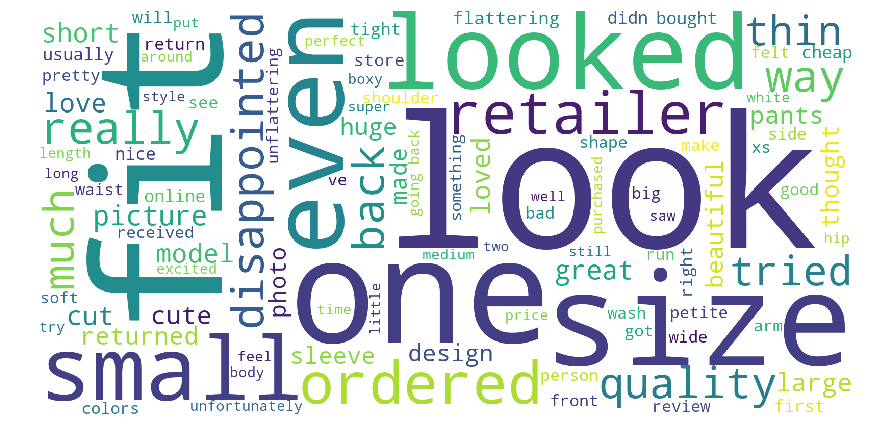

In [26]:
#  Rating = 1 Top Words
rating1 = clothing[clothing['Rating']==1]['Review Text'].apply(clean_data)
create_cloud(rating1)

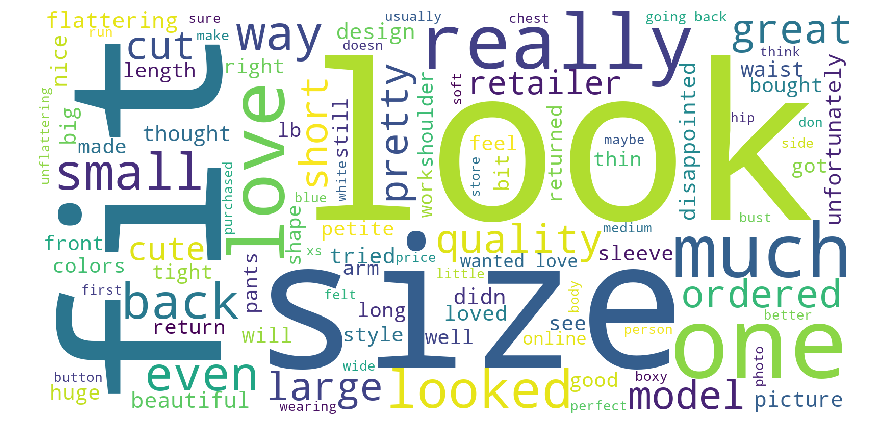

In [27]:
#  Rating = 2 Top Words
rating2 = clothing[clothing['Rating']==2]['Review Text'].apply(clean_data)
create_cloud(rating2)

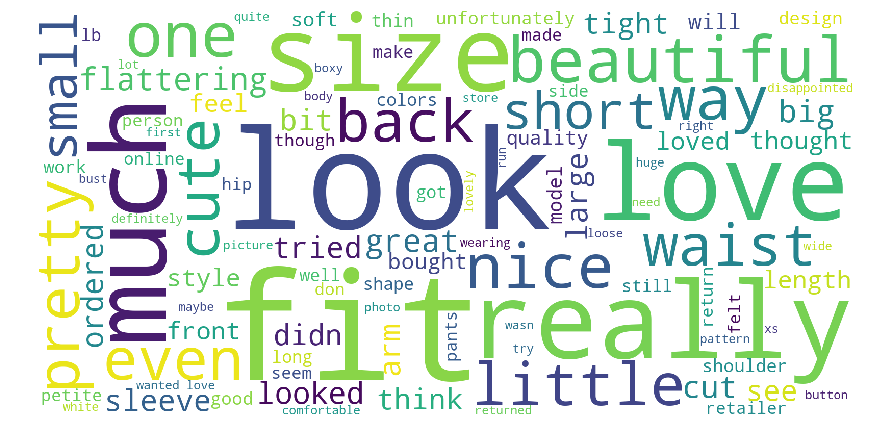

In [28]:
#  Rating = 3 Top Words
rating3 = clothing[clothing['Rating']==3]['Review Text'].apply(clean_data)
create_cloud(rating3)

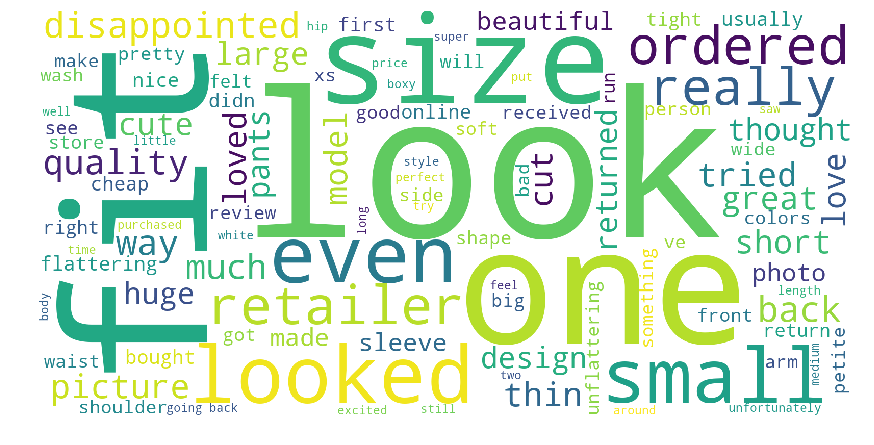

In [29]:
#  Rating = 4 Top Words
rating4 = clothing[clothing['Rating']==4]['Review Text'].apply(clean_data)
create_cloud(rating1)

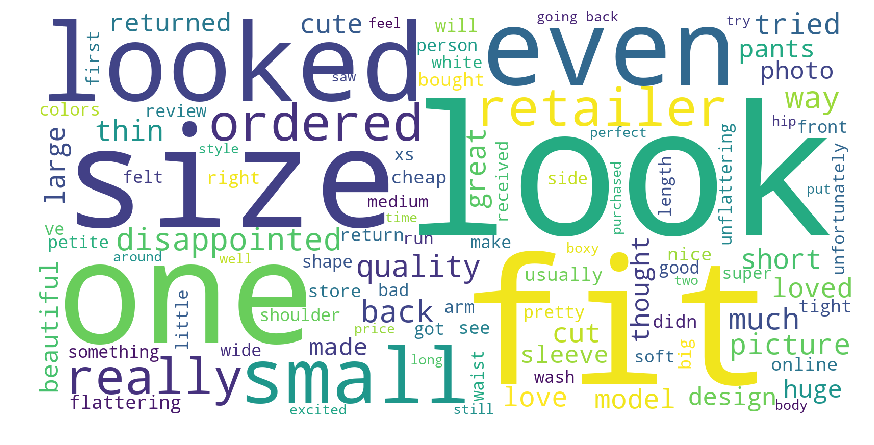

In [30]:
#  Rating = 5 Top Words
rating5 = clothing[clothing['Rating']==5]['Review Text'].apply(clean_data)
create_cloud(rating1)

In [31]:
clothing.loc[(clothing.Rating==1) & (clothing['Recommended IND']==1)]['Review Text'].iloc[1]

'Very cute top. i went down a size because for me it was a little large in the back, but that was just my taste. i purchased the denim print.'

In [32]:
clothing.loc[(clothing.Rating==5) & (clothing['Recommended IND']==0)]['Review Text'].iloc[1]

"This top is one of my retailer faves! it is so comfortable and love the quality and design. i receive many compliments on this top. i usually wear an xs or s in retailer tops and the xs was a little tight in the arms. the dressing room attendant suggested ordering a petite small so i wouldn't lose the shape. so glad i did. it fits perfect! i even ordered when it was on sale!! the gray color is perfect! its not too thick or thin."

In [33]:
#  Test Features - Preprocessing 
#  Dropping Punctuation
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [34]:
def punctuation_removal(messy_string):
    clean_list = [char for char in messy_string if char not in string.punctuation]
    clean_string = ''.join(clean_list)
    return clean_string

In [35]:
clothing['Review Text'] = clothing['Review Text'].apply(punctuation_removal)
clothing['Review Text'].head()

0    Absolutely wonderful  silky and sexy and comfo...
1    Love this dress  its sooo pretty  i happened t...
2    I had such high hopes for this dress and reall...
3    I love love love this jumpsuit its fun flirty ...
4    This shirt is very flattering to all due to th...
Name: Review Text, dtype: object

In [36]:
#  The Positiveness or Negativeness of the Reviews are mostly reflected by Verbs & Adjectives
def adj_collector(review_string):
    new_string=[]
    review_string = word_tokenize(review_string)
    tup_word = nltk.pos_tag(review_string)
    for tup in tup_word:
        if 'VB' in tup[1] or tup[1]=='JJ':  #  Adjectives  &  Verbs
            new_string.append(tup[0])  
    return ' '.join(new_string)

In [37]:
clothing['Review Text'] = clothing['Review Text'].apply(adj_collector)
clothing['Review Text'].head(7)

0                                wonderful comfortable
1    Love happened find im did have ordered online ...
2    had such high wanted work i ordered small usua...
3                  love love fabulous wear i get great
4    is flattering due adjustable is perfect wear i...
5    love reese is petite am tall wear was is long ...
6    aded last see look i went am pale is gorgeous ...
Name: Review Text, dtype: object

In [38]:
#  Stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.append("i'm")

In [39]:
#  Punctuation Removal of Stopwords
stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 
print(stop_words[::12])

['i', 'youd', 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', 'dont', 'aren', 'haven', 'shant']


In [40]:
#  Adding Clothing Stopwords
#  Same as the Stopwords we defined in building the WordCloud
clothing_list =['dress', 'top','sweater','shirt', 'blouse', 'pant', 'pants',
               'skirt','material', 'white', 'black', 'bottom', 'jacket',
              'jean', 'jeans', 'fabric', 'color', 'order', 'wear', 'dresse']

In [41]:
def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words and word.lower() not in clothing_list ]

In [42]:
clothing['Review Text'] = clothing['Review Text'].apply(stopwords_removal)
clothing['Review Text'].head()

0                             [wonderful, comfortable]
1    [love, happened, find, ordered, online, bc, bo...
2    [high, wanted, work, ordered, small, usual, fo...
3                   [love, love, fabulous, get, great]
4    [flattering, due, adjustable, perfect, pairs, ...
Name: Review Text, dtype: object

In [43]:
print(clothing['Review Text'][762]) 

['cute', 'scratchy']


In [44]:
print(clothing['Review Text'][1033])

['fell', 'ordered', 'available', 'ordered', 'blue', 'beautiful', 'contains', 'soft', 'heavy', 'great', 'conspicuous', 'said']


In [45]:
#  Removing All Numbers Including Size, Weight etc.
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

In [46]:
clothing['Review Text'] = clothing['Review Text'].apply(drop_numbers)
clothing['Review Text'].head()

0                                wonderful comfortable
1    love happened find ordered online bc bought lo...
2    high wanted work ordered small usual found sma...
3                         love love fabulous get great
4     flattering due adjustable perfect pairs cardigan
Name: Review Text, dtype: object

In [47]:
print(clothing['Review Text'][3922])

looked made stretchy looking rigid nice fit expect hemming sized flattering curvy imagine rear placed low giving


In [48]:
print(clothing['Review Text'][762]) 

cute scratchy


In [49]:
#  Stemming
porter = PorterStemmer()

clothing['Review Text'] = clothing['Review Text'].apply(lambda x: x.split())
clothing['Review Text'].head()

0                             [wonderful, comfortable]
1    [love, happened, find, ordered, online, bc, bo...
2    [high, wanted, work, ordered, small, usual, fo...
3                   [love, love, fabulous, get, great]
4    [flattering, due, adjustable, perfect, pairs, ...
Name: Review Text, dtype: object

In [50]:
def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = porter.stem(word)
        text_list_new.append(word) 
    return text_list_new

In [51]:
clothing['Review Text'] = clothing['Review Text'].apply(stem_update)
clothing['Review Text'].head()

0                                    [wonder, comfort]
1    [love, happen, find, order, onlin, bc, bought,...
2    [high, want, work, order, small, usual, found,...
3                      [love, love, fabul, get, great]
4      [flatter, due, adjust, perfect, pair, cardigan]
Name: Review Text, dtype: object

In [52]:
clothing['Review Text'] = clothing['Review Text'].apply(lambda x: ' '.join(x))
clothing['Review Text'].head()

0                                       wonder comfort
1    love happen find order onlin bc bought love hi...
2    high want work order small usual found small s...
3                            love love fabul get great
4             flatter due adjust perfect pair cardigan
Name: Review Text, dtype: object

In [53]:
print(clothing['Review Text'][3922])

look made stretchi look rigid nice fit expect hem size flatter curvi imagin rear place low give


In [54]:
print(clothing["Review Text"])

0                                           wonder comfort
1        love happen find order onlin bc bought love hi...
2        high want work order small usual found small s...
3                                love love fabul get great
4                 flatter due adjust perfect pair cardigan
                               ...                        
23481                   happi snag great easi slip flatter
23482    remind soft stretchi shini flatter found close...
23483                      work abl tri onlin differ great
23484    bought cute perfect fit big want spend get tai...
23485                love feminin fit easi comfi recommend
Name: Review Text, Length: 22641, dtype: object


In [55]:
#  Sentiment Analysis
# Pre-Processing
SIA = SentimentIntensityAnalyzer()

# Apply Model, Variable Creation
clothing['Polarity Score'] = clothing["Review Text"].apply(lambda x:SIA.polarity_scores(x)['compound'])
clothing['Neutral Score'] = clothing["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neu'])
clothing['Negative Score'] = clothing["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neg'])
clothing['Positive Score'] = clothing["Review Text"].apply(lambda x:SIA.polarity_scores(x)['pos'])

# Convert 0 to 1 Decimal Score to a Categorical Variable
clothing['Sentiment']=''
clothing.loc[clothing['Polarity Score']>0,'Sentiment']='Positive'
clothing.loc[clothing['Polarity Score']==0,'Sentiment']='Neutral'
clothing.loc[clothing['Polarity Score']<0,'Sentiment']='Negative'

In [56]:
conditions = [
    clothing['Sentiment'] == "Positive",
    clothing['Sentiment'] == "Negative",
    clothing['Sentiment'] == "Neutral"]
choices = [1,-1,0]
clothing['label'] = np.select(conditions, choices)
clothing.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Polarity Score,Neutral Score,Negative Score,Positive Score,Sentiment,label
0,767,33,NaN,wonder comfort,4,1,0,Initmates,Intimate,Intimates,0.3612,0.286,0.0,0.714,Positive,1
1,1080,34,NaN,love happen find order onlin bc bought love hi...,5,1,4,General,Dresses,Dresses,0.9042,0.446,0.0,0.554,Positive,1
2,1077,60,Some major design flaws,high want work order small usual found small s...,3,0,0,General,Dresses,Dresses,0.7579,0.679,0.0,0.321,Positive,1
3,1049,50,My favorite buy!,love love fabul get great,5,1,0,General Petite,Bottoms,Pants,0.9260,0.138,0.0,0.862,Positive,1
4,847,47,Flattering shirt,flatter due adjust perfect pair cardigan,5,1,6,General,Tops,Blouses,0.6249,0.440,0.0,0.560,Positive,1


In [57]:
#  RNN
samples = clothing["Review Text"].tolist()
maxlen = 100 
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print('Found %s Unique Tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

Found 7413 Unique Tokens.


In [58]:
labels = np.asarray(clothing["label"].values)
print('Data Tensor Shape :', data.shape)
print('Label Tensor Shape :', labels.shape)

Data Tensor Shape : (22641, 100)
Label Tensor Shape : (22641,)


In [59]:
indices = np.arange(clothing.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [60]:
training_samples = 11743
validation_samples = 17614

In [61]:
x_train = data[:training_samples]
y_train = labels[:training_samples]

In [62]:
x_val = data[training_samples: validation_samples] 
y_val = labels[training_samples: validation_samples]

In [63]:
x_test = data[validation_samples:]
y_test = labels[validation_samples:]

In [64]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

In [65]:
def build_RNN():
    model = Sequential() 
    model.add(Embedding(max_words, 100, input_length=maxlen)) 
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32)) 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 
    return model

In [66]:
model = build_RNN()
model.summary()
history_RNN = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save("RNN.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100, 32)           4256      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,006,369
Trainable params: 1,006,369
Non-trainable params: 0
_________________________________________________________________
Train on 11743 samples, validate on 5871 samples
Epoch 1/5
11743/11743 [==============================] - 66s 6ms/step - loss: 0.2405 - acc: 0.8729 - val_loss: 0.0639 - val_acc: 0.8780
Epoch 2/5
11743/11743 [==============================] - 

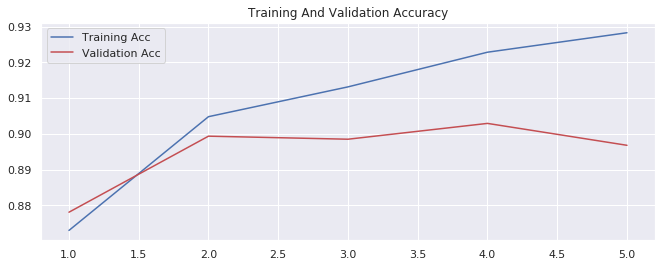

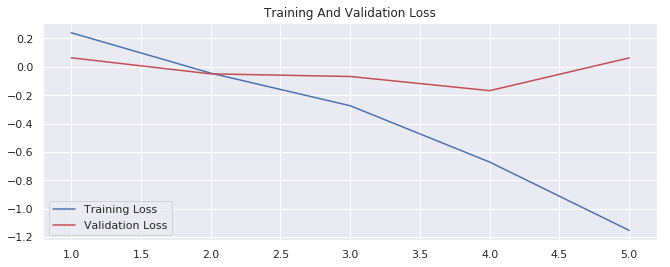

In [67]:
acc = history_RNN.history['acc']
val_acc = history_RNN.history['val_acc']
loss = history_RNN.history['loss']
val_loss = history_RNN.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'r', label='Validation Acc')
plt.title('Training And Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training And Validation Loss')
plt.legend()
plt.show()

In [68]:
model.evaluate(x_test, y_test)

5027/5027 [==============================] - 11s 2ms/step


[0.12257763740071732, 0.8925800919532776]

In [69]:
#  Simple Embedding Deep Neural Network
def build_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
    return model

In [70]:
model = build_model()
model.summary()
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save("DNN.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,642,177
Trainable params: 1,642,177
Non-trainable params: 0
_________________________________________________________________
Train on 11743 samples, validate on 5871 samples
Epoch 1/5
11743/11743 [==============================] - 2s 1

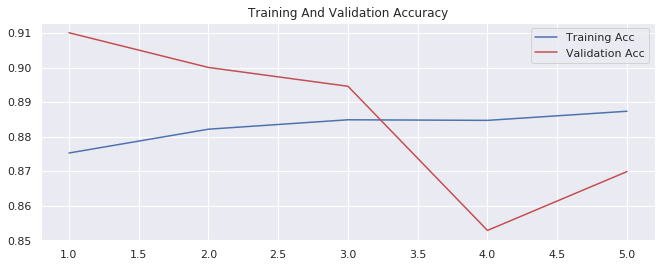

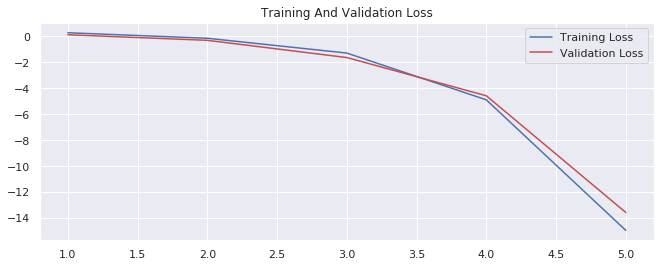

In [71]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'r', label='Validation Acc')
plt.title('Training And Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training And Validation Loss')
plt.legend()
plt.show()

In [72]:
model.evaluate(x_test, y_test)

5027/5027 [==============================] - 0s 54us/step


[-12.37767839384278, 0.8667197227478027]